# Model validation with observation data: River discharge and Well WTD

In this notebook, the modeled river discharge (Q) and saturated zone water table depth (WTD) are compared with river gauge and well observation timeseries. The data are first loaded and spatially visualized and the timeseries of simulated and observed pairs are plotted for comparison. The package [ModelSkill](https://github.com/DHI/modelskill.git) is utilized for generating statistics (NSE, KGE, RMSE, etc.) and evaluating model performance.

<!-- IN PROGRESS:  Validate surface water extent with JRC surface water frequency map? or S2 NDWI maps? Need to see if there is any serious surface water here -->


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import geopandas as gpd
import mikeio
import shapely
import glob
import os
import pandas as pd
import modelskill as ms
import re


In [2]:
# Functions
def plot_settings(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    # remove plot border
    for spine in ax.spines.values():
        spine.set_visible(False)

def nse_rmse_statistics(Q_mod, Q_obs):
    """
    Compute Nash-Sutcliffe Efficiency (NSE) and Root Mean Square Error (RMSE)
    for modeled and observed discharge data.
    """
    # remove NaN values - dropping the same rows from both series
    valid_mask = Q_mod.notna() & Q_obs.notna()
    Q_mod = Q_mod[valid_mask]
    Q_obs = Q_obs[valid_mask]
    print()
    nse = 1 - ((Q_obs - Q_mod) ** 2).sum() / ((Q_obs - Q_obs.mean()) ** 2).sum()
    rmse = ((Q_obs - Q_mod) ** 2).mean() ** 0.5
    return nse, rmse

In [3]:
# ---------------------- Station Information ----------------------
chainage_dict = {"Q250018" : -3764,
        "Q250019" : -30794,
        "Q250020" : -3681,
        "Q250021" : 3900,
        "Q250078" : 26434,
        "Q250082" : 54135,
        "Q250090" : -2400,
        "Q250092" : -10576,
        "Q250097" : 61000

}

branch_dict = {"Q250018" : 'SKJERN_AA_DK5',
        "Q250019" : 'SDR_OMME_AA_DK5',
        "Q250020" : 'HOLTUM_AA_DK5',
        "Q250021" : 'BRANDE_AA_DK5',
        "Q250078" : 'SDR_OMME_AA_DK5',
        "Q250082" : 'SKJERN_AA_DK5',
        "Q250090" : 'SDR_OMME_AA_DK5',
        "Q250092" : 'GUNDESBOEL_AA_DK5',
        "Q250097" : 'SKJERN_AA_DK5'

}

C:\Users\safr\AppData\Local\Temp\ipykernel_30368\1340886726.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  river_gauge_loc = pd.concat([river_gauge_loc, loc_temp], ignore_index=True)


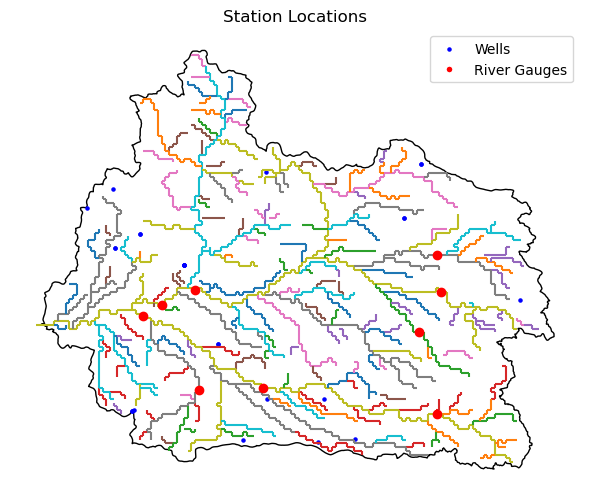

In [4]:
# ---------------------- Plot Domain, River Connectivity, Discharge stations ----------------------

fig, ax = plt.subplots(figsize=(6, 6))

# Domain data
domain_shp = gpd.read_file( r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")
domain_shp.plot(facecolor='none', edgecolor='black',ax=ax)

# River connectivity shapefile (simulation output)
riv_shp = gpd.read_file(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHI_RiverLinks.shp")
riv_shp.plot(column='Branch',ax=ax)
plot_settings(ax)

river_gauge_loc = pd.DataFrame(columns=['stationID', 'x', 'y'])

# Plot locations of river discharge stations
for stationID in branch_dict.keys():
    branch = branch_dict[stationID]
    chainage = chainage_dict[stationID]
    river = riv_shp.loc[riv_shp['Branch'] == branch]

    # get closest chainage
    closest_chain = river.iloc[(river['Chainage']-chainage).abs().argsort()[:1]]

    # get centroid of closest_chain
    centroid = shapely.centroid(closest_chain.geometry)
    centroid.plot(ax=ax,color='red',zorder=2)
    xloc = float(centroid.x.iloc[0])
    yloc = float(centroid.y.iloc[0])

    # store x and y coordinates in a DataFrame
    loc_temp = pd.DataFrame({'stationID': [stationID], 'x': [xloc], 'y': [yloc]})
    river_gauge_loc = pd.concat([river_gauge_loc, loc_temp], ignore_index=True)

    # plot stationID next to point
    # plt.text(x=xloc,y=yloc,s=stationID)

plt.title('Station Locations')

# Read in well locations
well_loc = gpd.read_file(r"..\MapsDK\Hdata\head_evel_SZ.csv")
well_loc = gpd.GeoDataFrame(well_loc, geometry=gpd.points_from_xy(well_loc['x'], well_loc['y']))
well_loc = well_loc.set_crs(domain_shp.crs)
well_loc.plot(ax=ax, color='blue', markersize=5, label='Wells')

# Add legend with manually specified labels
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='River Gauges', markerfacecolor='red', markersize=5))
ax.legend(handles=handles, loc='upper right')
plt.tight_layout()

In [5]:
# ---------------------- Load modeled and observed river discharge and water table depth (WTD) ----------------------


# Load Q observations
Q_obs = mikeio.read(r"..\MapsDK\Qdata\Q_filtered.dfs0")
Q_obs = Q_obs.to_dataframe()


# Load well obs (WTD)
well_obs = pd.DataFrame()
for filename in glob.glob(r"..\MapsDK\Hdata\Hdata_filtered\*.dfs0"):
    temp = mikeio.read(filename)
    temp = temp[0].to_dataframe()
    temp.columns = ['WTD']
    stationID = os.path.basename(filename)[0:-5]
    temp['StationID'] = stationID
    # set index to datetime
    temp.index = pd.to_datetime(temp.index)

    well_obs = pd.concat([well_obs, temp])

# Load modeled Q
Q_mod = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHIDetailedTS_M11.dfs0")
Q_mod = Q_mod.to_dataframe()

# Load modeled WTD
Wtd_SZ_mod = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHIDetailedTS_SZ.dfs0")
Wtd_SZ_mod = Wtd_SZ_mod.to_dataframe()


In [6]:
# ---------------------- Validation statistics for river discharge ----------------------

nse_rmse_results = {}
for stationID in branch_dict.keys():

    # combine data by date
    mod_daily = Q_mod[stationID].resample('D').mean()
    obs_daily = Q_obs[stationID].resample('D').mean()
    combined = mod_daily.to_frame(name='Modeled Q').join(obs_daily.to_frame(name='Observed Q'))

    # drop rows with NaN values
    combined = combined.dropna()
    
    nse, rmse = nse_rmse_statistics(combined['Modeled Q'], combined['Observed Q'])
    nse_rmse_results[stationID] = {'NSE': nse, 'RMSE': rmse}

for stationID, stats in nse_rmse_results.items():
    print(f"Station {stationID}: NSE = {stats['NSE']:.3f}, RMSE = {stats['RMSE']:.3f}")











Station Q250018: NSE = 0.096, RMSE = 0.477
Station Q250019: NSE = 0.574, RMSE = 0.550
Station Q250020: NSE = 0.586, RMSE = 0.282
Station Q250021: NSE = 0.612, RMSE = 0.171
Station Q250078: NSE = 0.800, RMSE = 2.176
Station Q250082: NSE = 0.786, RMSE = 3.262
Station Q250090: NSE = 0.655, RMSE = 1.106
Station Q250092: NSE = 0.657, RMSE = 0.487
Station Q250097: NSE = 0.672, RMSE = 6.244


Text(0.02, 0.5, 'Discharge (m³/s)')

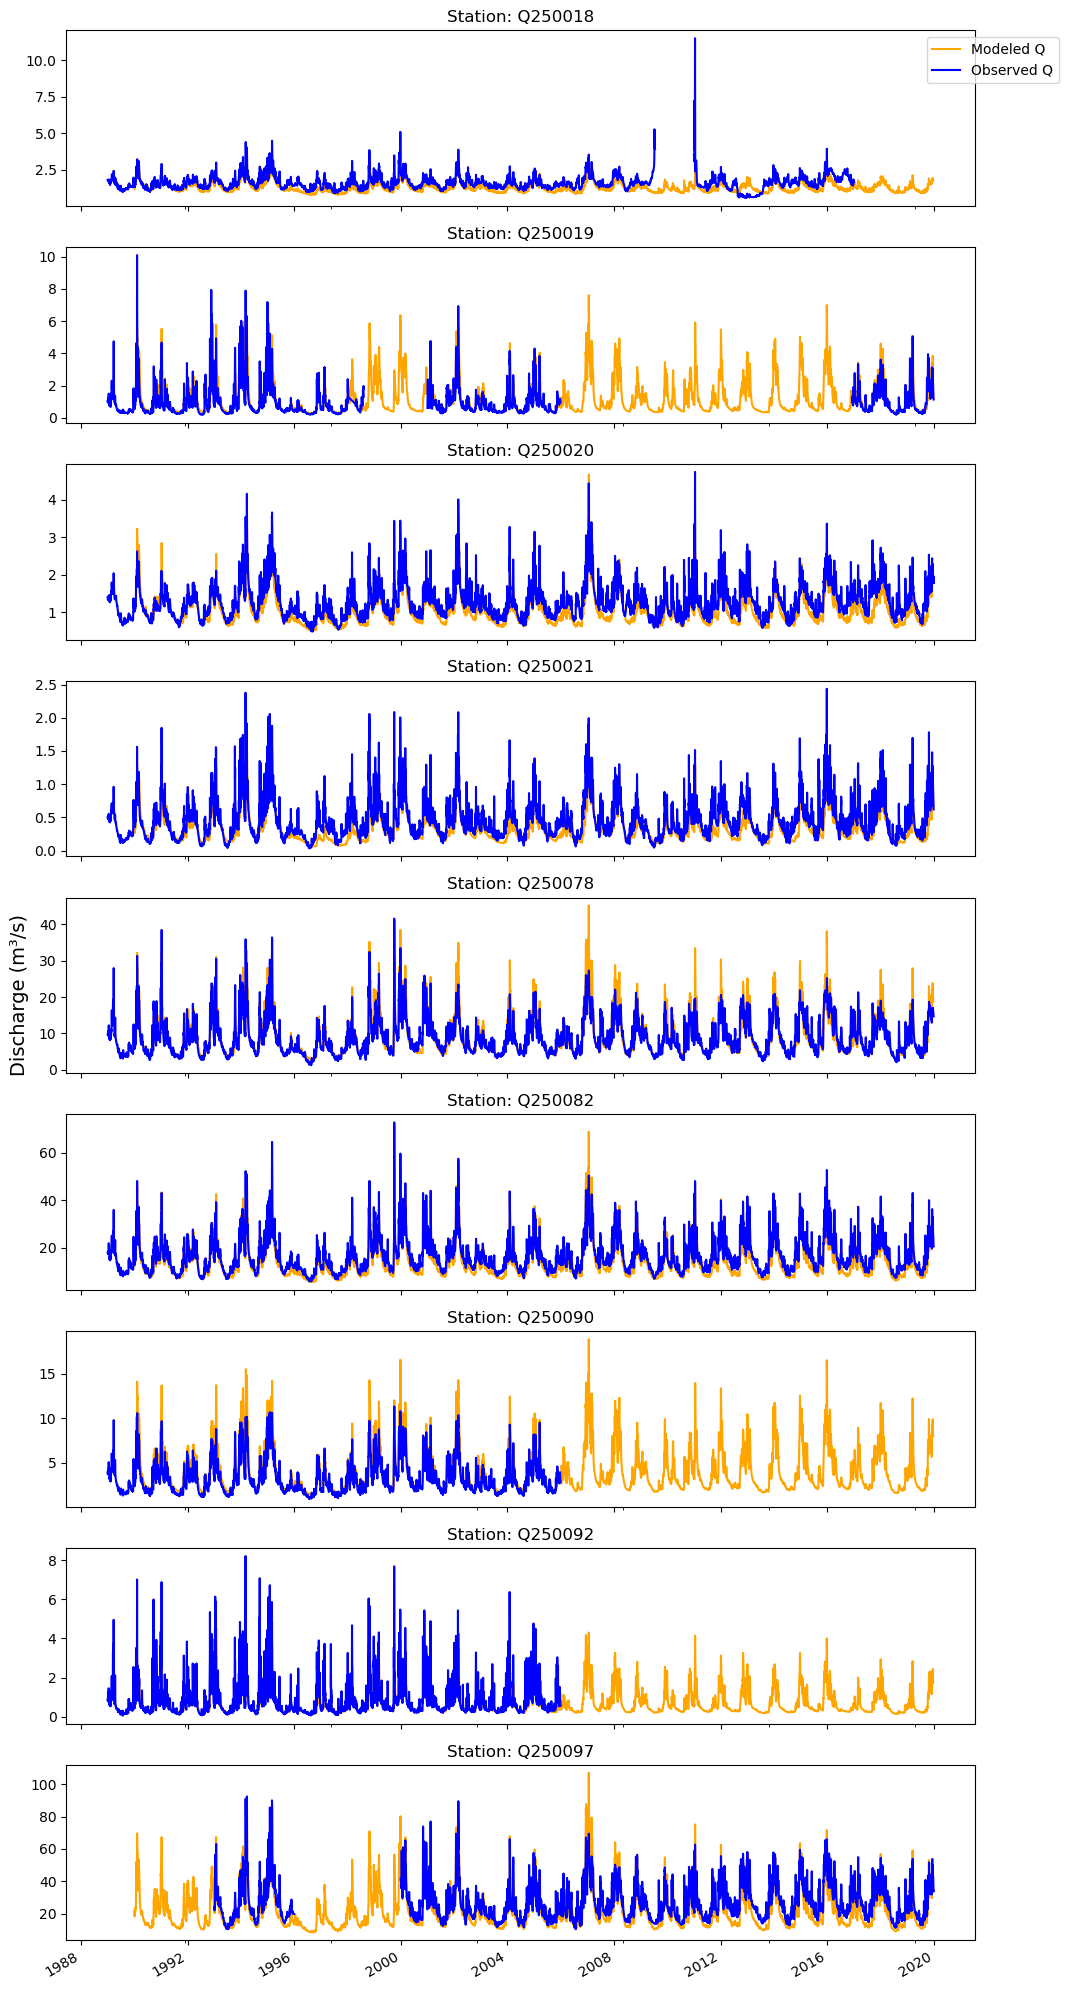

In [7]:
# ---------------------- Plot modeled vs observed Q for each station ----------------------

fig, ax = plt.subplots(nrows=len(branch_dict),ncols=1,sharex=True,figsize=(10,20))
i=0
for stationID in branch_dict.keys():
    
    Q_mod[stationID].plot(ax=ax[i], label=f'Modeled Q', color='orange')
    Q_obs[stationID].plot(ax=ax[i], label=f'Observed Q', color='blue')
    ax[i].set_title(f'Station: {stationID}')

    # nse = nse_rmse_results[stationID]['NSE']
    # rmse = nse_rmse_results[stationID]['RMSE']
    # ax[i].text(0.05, 0.95, f'NSE: {nse:.3f}\nRMSE: {rmse:.3f}', transform=ax[i].transAxes, fontsize=10, verticalalignment='top')
    i += 1

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=ax[0].transAxes)
plt.tight_layout(rect=(0.025,0,1,1))

#fig.suptitle('Modeled vs Observed Discharge at River Stations', fontsize=16)
fig.supylabel('Discharge (m³/s)', fontsize=14)


<Axes: title={'center': 'Skjern_100m vs Q250019'}, xlabel='Observation, Discharge [m3/s]', ylabel='Model, Discharge [m3/s]'>

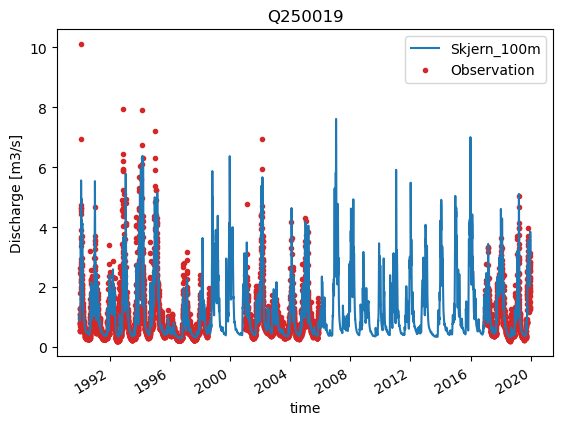

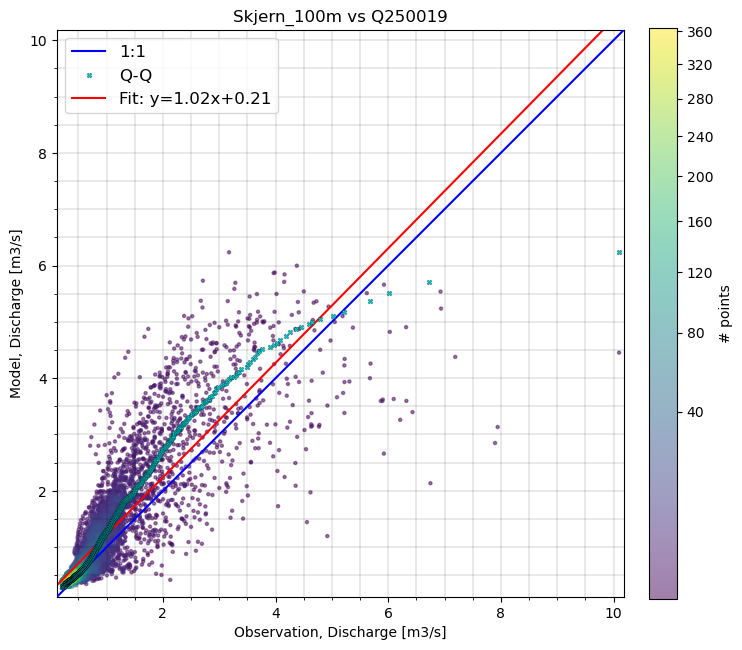

In [8]:
# ---------------------- Assess model results using ModelSkill ----------------------

stationID = 'Q250019'  # example station ID

def get_comparer(df_obs,df_mod, stationID, station_loc_df):
    """Get a Comparer object for a given model and station id"""
    # create Quantity object
    q = ms.Quantity(name="Discharge", unit="m3/s")

    # create Observation objects (assuming several stations)
    df_station = df_obs[stationID]
    xloc = station_loc_df.loc[station_loc_df.stationID == stationID].x.iloc[0]
    yloc = station_loc_df.loc[station_loc_df.stationID == stationID].y.iloc[0]
    o = ms.PointObservation(df_station, item=None, name=stationID,
                            x=xloc, y=yloc, quantity=q)

    # create ModelResult object (assuming one model)
    m = ms.PointModelResult(df_mod[stationID], item=None, name='Skjern_100m', quantity=q)
    
    return ms.match(obs=o, mod=m)

cmp = get_comparer(Q_obs, Q_mod, stationID, river_gauge_loc)

# plot timeseries
cmp.plot.timeseries()

# plot scatter plot
cmp.sel(model="Skjern_100m").plot.scatter()


In [ ]:
# ModelSkill summary statistics - run through each station and matching model output

showPlots = False
ms.options.metrics.list = ["kge", "cc","nse","rmse"]

all_stats = pd.DataFrame()
for stationID in branch_dict.keys():
    cmp = get_comparer(Q_obs, Q_mod, stationID, river_gauge_loc)

    if showPlots == True:
        # plot timeseries
        cmp.plot.timeseries()
        # plot scatter plot
        cmp.sel(model="Skjern_100m").plot.scatter()

    temp_stats = cmp.skill().round(3)
    all_stats = pd.concat([all_stats,temp_stats])

print("ModelSkill Summary Statistics:")
print(all_stats)

# print average statistics across all stations
avg_stats = all_stats.mean().round(3)
print("\nAverage Statistics Across All Stations:")
print(avg_stats)

ModelSkill Summary Statistics:
                 n    kge     cc    nse   rmse         x          y
observation                                                        
Q250018       9327  0.530  0.681  0.090  0.479  514750.0  6201000.0
Q250019       6079  0.653  0.846  0.521  0.582  514250.0  6184500.0
Q250020      10947  0.803  0.874  0.562  0.290  514250.0  6206000.0
Q250021      10947  0.694  0.840  0.582  0.178  511750.0  6195500.0
Q250078      10947  0.796  0.936  0.808  2.130  474500.0  6197750.0
Q250082      10947  0.840  0.940  0.790  3.233  481500.0  6201250.0
Q250090       5842  0.630  0.946  0.642  1.127  490750.0  6188000.0
Q250092       5842  0.657  0.771  0.584  0.536  482000.0  6187750.0
Q250097       8392  0.776  0.917  0.673  6.236  477000.0  6199250.0

Average Statistics Across All Stations:
n          8807.778
kge           0.709
cc            0.861
nse           0.584
rmse          1.643
x        495638.889
y       6195666.667
dtype: float64


### ModelSkill evaluation takeaways:

Across all river discharge stations, we have an average KGE of **0.709**, correlation of **0.861**, NSE of **0.584**, and RMSE of **1.643**. So, the model is performing much better than the benchmark mean (>-0.4 KGE and NSE>0), and the relatively high positive KGE and NSE imply that the model has decent predictive abilities. Observations and simulated values are highly correlated, and the RMSE overall is less than 2 m.

From the timeseries plots, we can see in a few cases that the model underpredicts high flows (see Q250097 and Q250090). However in most of the cases, the high flow signal is captured and occasionally overestimated (see Q250092, Q250021, Q250020, Q250018).

In [10]:
# ---------------------- Validation statistics for WTD ----------------------

# resort this dataframe to have unique stationIDs as columns
well_obs['time'] = well_obs.index
wells_obs_long = well_obs.pivot_table(index='time', columns='StationID', values='WTD')


nse_rmse_results_wells = {}
for wellID in wells_obs_long.columns:

    # combine data by date
    mod_daily = Wtd_SZ_mod[wellID].resample('D').mean()
    obs_daily = wells_obs_long[wellID].resample('D').mean()
    combined = mod_daily.to_frame(name='Modeled WTD').join(obs_daily.to_frame(name='Observed WTD'))

    # drop rows with NaN values
    combined = combined.dropna()
    
    nse, rmse = nse_rmse_statistics(combined['Modeled WTD'], combined['Observed WTD'])
    nse_rmse_results_wells[wellID] = {'NSE': nse, 'RMSE': rmse}

for wellID, stats in nse_rmse_results_wells.items():
    print(f"Well {wellID}: NSE = {stats['NSE']:.3f}, RMSE = {stats['RMSE']:.3f}")





























Well 102.725_1: NSE = -325.764, RMSE = 17.184
Well 102.725_2: NSE = -547.758, RMSE = 17.452
Well 102.873_1: NSE = -1276.528, RMSE = 14.166
Well 103.1542_1: NSE = -10.435, RMSE = 1.271
Well 103.1653_1: NSE = -323.791, RMSE = 4.130
Well 103.1653_2: NSE = -0.078, RMSE = 0.242
Well 104.2190_1: NSE = -7.715, RMSE = 1.116
Well 105.374_1: NSE = -340.148, RMSE = 7.806
Well 113.111_1: NSE = -0.213, RMSE = 0.401
Well 114.1618_6: NSE = -3.209, RMSE = 1.555
Well 114.1631_1: NSE = -11.928, RMSE = 0.686
Well 83.1175_1: NSE = -7.074, RMSE = 1.222
Well 84.1167_1: NSE = -6.754, RMSE = 0.923
Well 86.2056_1: NSE = -36.388, RMSE = 1.410
Well 86.2056_2: NSE = -18.124, RMSE = 1.085
Well 93.1062_2: NSE = -19.664, RMSE = 1.683
Well 93.1062_3: NSE = -23.127, RMSE = 1.842
Well 93.795_1: NSE = -2355.340, RMSE = 10.350
Well 94.1920_1: NSE = -5.452, RMSE = 7.770
Well 94.1920_2: NSE = -16.051, RMSE = 4.247
Well 94.2476_1: NSE = -54.495, RMSE = 3.185
Well 94.2476_2: NSE = -53.156, RMSE = 3

Text(0.02, 0.5, 'WTD (m)')

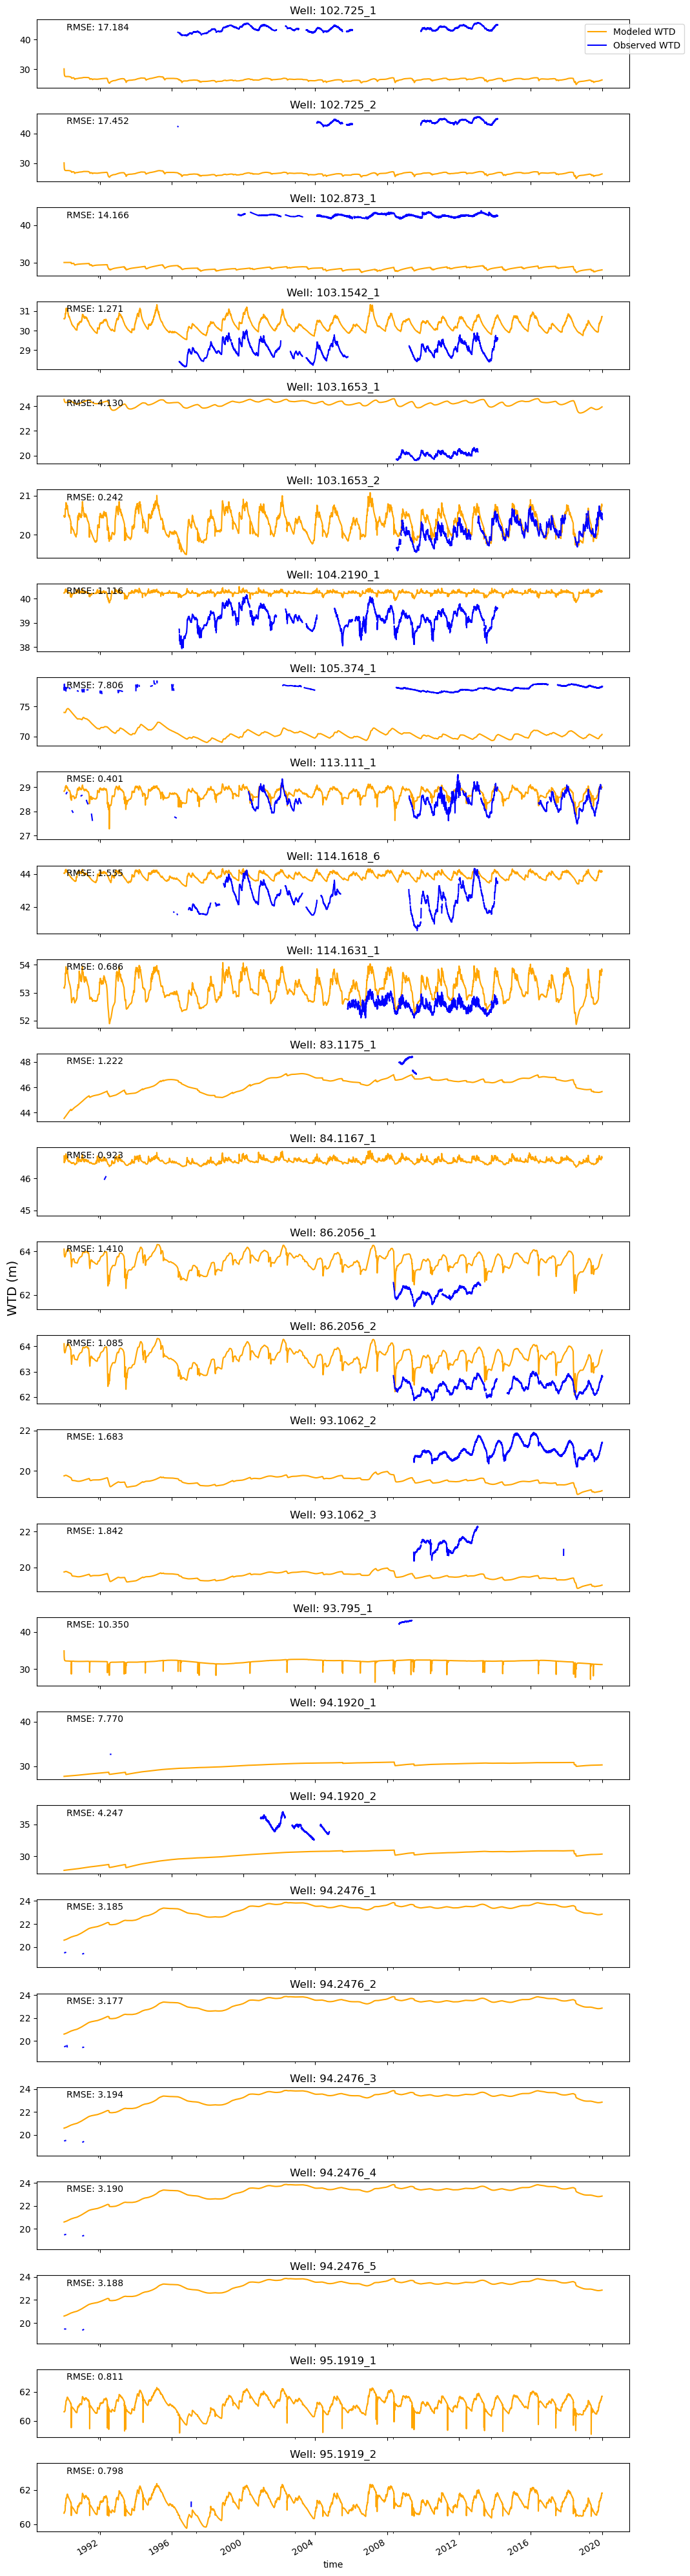

In [11]:
# ---------------------- Plot modeled vs observed maps of WTD for time slices ----------------------

fig, ax = plt.subplots(nrows=len(wells_obs_long.columns),ncols=1,sharex=True,figsize=(10,40))
i=0
for wellID in wells_obs_long.columns:
    
    Wtd_SZ_mod[wellID].plot(ax=ax[i], label=f'Modeled WTD', color='orange')
    wells_obs_long[wellID].plot(ax=ax[i], label=f'Observed WTD', color='blue')
    ax[i].set_title(f'Well: {wellID}')

    rmse = nse_rmse_results_wells[wellID]['RMSE']
    ax[i].text(0.05, 0.95, f'RMSE: {rmse:.3f}', transform=ax[i].transAxes, fontsize=10, verticalalignment='top')
    i += 1


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=ax[0].transAxes)
plt.tight_layout(rect=(0.025,0,1,1))

fig.supylabel('WTD (m)', fontsize=14)

Summary of RMSE by Layer
-----------------------------------
Layer 1     | RMSE: 8.6691   | Data Points: 32661  | Wells: 15
Layer 2     | RMSE: 6.8460   | Data Points: 13642  | Wells: 7
Layer 3     | RMSE: 2.0499   | Data Points: 1272   | Wells: 2
Layer 4     | RMSE: 3.1904   | Data Points: 152    | Wells: 1
Layer 5     | RMSE: 3.1881   | Data Points: 152    | Wells: 1
Layer 6     | RMSE: 1.5549   | Data Points: 3871   | Wells: 1


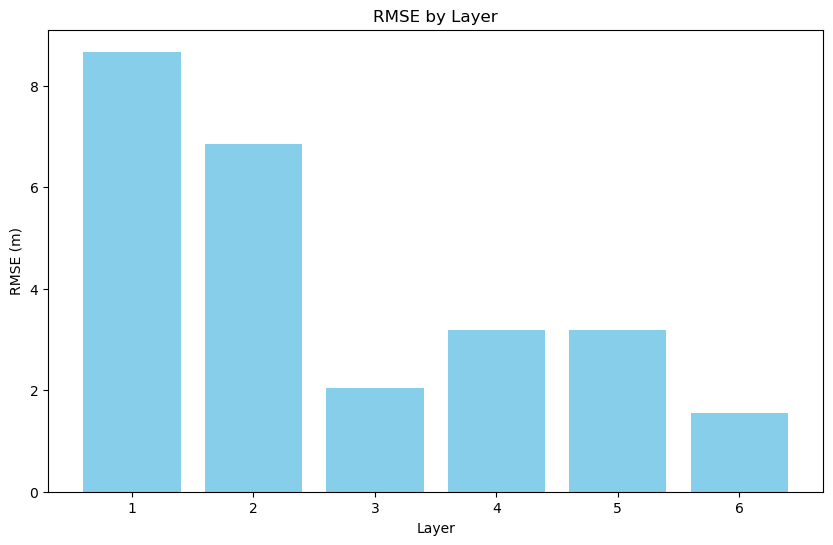

In [12]:
# ---------------------- Plot RMSE for each layer ----------------------

# Aggregate by layer
groups = {}
for col in wells_obs_long.columns:
    match = re.search(r'_(\d+)$', col)
    if match:
        suffix = match.group(1)
        if suffix not in groups:
            groups[suffix] = []
        groups[suffix].append(col)

# separate dataframes by each layer, stored in a dictionary
wells_obs_layers = {suffix: wells_obs_long[cols] for suffix, cols in groups.items()}
wells_mod_layers = {suffix: Wtd_SZ_mod[cols] for suffix, cols in groups.items()}


# Calculate RMSE for each layer
rmse_by_layer = {}
for layer, cols in wells_obs_layers.items():
    mod_daily = wells_mod_layers[layer].resample('D').mean()
    obs_daily = wells_obs_layers[layer].resample('D').mean()

    # align
    obs_daily = obs_daily[mod_daily.columns]
    mod_daily = mod_daily[obs_daily.columns]
    obs_df, mod_df = obs_daily.align(mod_daily, join='inner') # This joins data only present in both DataFrames

    assert obs_df.columns.equals(mod_df.columns), "Station columns are mismatched!"
    assert obs_df.index.equals(mod_df.index), "Timestamps are mismatched!"

    # # Compute RMSE for the entire dataframe (all values flattened)
    rmse = ((obs_df - mod_df) ** 2).stack().mean() ** 0.5

    # remove NaN values
    non_nan_count = obs_df.count().sum()

    # Store rmse and total number of data points for each layer in a dictionary
    rmse_by_layer[layer] = {
        'RMSE': rmse,
        'Total Data Points': non_nan_count,
        'Number of Wells': obs_df.shape[1]
    }

# Plot RMSE vs layer, ordered by layer number
rmse_by_layer = dict(sorted(rmse_by_layer.items(), key=lambda item: int (item[0])))

fig, ax = plt.subplots(figsize=(10, 6))
layers = list(rmse_by_layer.keys())
rmse_values = [rmse_by_layer[layer]['RMSE'] for layer in layers]
ax.bar(layers, rmse_values, color='skyblue')
ax.set_xlabel('Layer')
ax.set_ylabel('RMSE (m)')
ax.set_title('RMSE by Layer')

# print number of data points for each layer
print("Summary of RMSE by Layer\n" + "-"*35)
for layer in layers:
    rmse = rmse_by_layer[layer]['RMSE']
    n_points = rmse_by_layer[layer]['Total Data Points']
    n_wells = rmse_by_layer[layer]['Number of Wells']
    
    print(f"Layer {layer:<5} | RMSE: {rmse:<8.4f} | Data Points: {n_points:<6} | Wells: {n_wells}")

